In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import pickle
from collections import Counter, defaultdict
from itertools import combinations

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.sparse import linalg
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# keep hindi and english
fulldata = pd.read_csv("../lite_data/india_July_21.csv", header=0)
fulldata.head()

,Unnamed: 0,domain,id,id_str,party,screen_name,state
0,0,1.0,784325894559059968,784325894559059968,To Be Added,Sanjay_Meshack,To Be Added
1,1,1.0,741171197342187521,741171197342187520,BJP,BJP4AnN,Andaman and Nicobar Islands
2,2,1.0,1283244990274002949,1283244990274002944,INC,NSubramanian1,To Be Added
3,3,1.0,935363557050298368,935363557050298368,INC,SatishYepuri,Andhra Pradesh
4,4,1.0,112384119,112384119,BJP,praveenkubjp,Bihar


In [3]:
fulldata.sample(5)

,Unnamed: 0,domain,id,id_str,party,screen_name,state
14983,14983,1.0,921248494165340161,921248494165340160,CPIM,b_kodiyeri,Kerala
13569,13569,1.0,83586157,83586157,INC,SalmanNizami_,To Be Added
7970,7970,1.0,2536794973,2536794973,SP,Bukkalnawab,Uttar Pradesh
27535,27535,NaN,973061796050415616,973061796050415616,INC,WhoNeverGivesUp,To Be Added
10678,10678,1.0,923523753010536449,923523753010536448,BJP,beenanaik123,Goa


In [4]:
fulldata.state.unique()

array(['To Be Added', 'Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Bihar', 'Maharashtra', 'Tamil Nadu', 'Manipur', 'Meghalaya',
       'Gujarat', 'Mizoram', 'Nagaland', 'Odisha', 'Overseas',
       'Puducherry', 'Chhattisgarh', 'Madhya Pradesh', 'Punjab',
       'Rajasthan', 'Delhi', 'Uttar Pradesh', 'Arunachal Pradesh',
       'Karnataka', 'Haryana', 'Uttarakhand', 'Telangana',
       'Himachal Pradesh', 'West Bengal', 'Tripura', 'Chandigarh',
       'Dadra and Nagar Haveli', 'Sikkim', 'Jammu and Kashmir',
       'Daman and Diu', 'Goa', 'Ladakh', 'Assam', 'Lakshadweep',
       'Jharkhand', 'Kerala'], dtype=object)

In [5]:
svd_embedding_size = 20

In [6]:
data = pd.read_csv("../lite_data/jan15_extracted_domains.csv", header=0)
data.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1.si,1
1,1,NaN,1950.today,1
2,2,NaN,4lakhdenahoga.com,2
3,3,NaN,54.xn--h2brj9c,1
4,4,NaN,5dariyanews.com,1


In [7]:
data1 = pd.read_csv("../lite_data/jan21_extracted_domains.csv", header=0)
data1.head()

,Unnamed: 0,author,domain,count
0,0,0099Swami,amritmahotsav.nic.in,1
1,1,0099Swami,bjym.org,2
2,2,0099Swami,eshram.gov.in,2
3,3,0099Swami,gujarat.gov.in,1
4,4,0099Swami,hindustantimes.com,1


In [8]:
data = pd.concat([data, data1])
data = data.dropna(subset=['author'])

In [9]:
news_domains = pd.read_csv("../lite_data/domaintitles_annotated_no_international.csv", header=0)
news_domains.head()

,Unnamed: 0,Unnamed: 0.1,domain,title_text,is_news,titleDEsc,international,if_annotated_international
0,0,0,indiatoday.in,"Latest News, Breaking News Today - Bollywood, ...",1.0,"indiatoday.in\nLatest News, Breaking News Toda...",domestic,True
1,1,3,prajavani.net,"Prajavani | ಪ್ರಜಾವಾಣಿ ತಾಜಾ ಸುದ್ದಿ, ಸಮಾಚಾರ, ವಾರ...",1.0,prajavani.net\nPrajavani | ಪ್ರಜಾವಾಣಿ ತಾಜಾ ಸುದ್...,domestic,True
2,2,4,thehindu.com,"\nThe Hindu: Breaking News, India News, Sports...",1.0,"thehindu.com\n\nThe Hindu: Breaking News, Indi...",domestic,True
3,3,6,abplive.com,"Hindi News, Breaking News in Hindi, हिंदी न्यू...",1.0,"abplive.com\nHindi News, Breaking News in Hind...",domestic,True
4,4,8,news18.com,"News, Breaking News, Latest News, News Headlin...",1.0,"news18.com\nNews, Breaking News, Latest News, ...",domestic,True


In [10]:
newslist = news_domains.loc[news_domains['international']=='domestic']['domain'].tolist()

In [11]:
print(newslist)

['indiatoday.in', 'prajavani.net', 'thehindu.com', 'abplive.com', 'news18.com', 'thedailystar.net', 'indiatimes.com', 'amarujala.com', 'livemint.com', 'business-standard.com', 'timesofindia.com', 'india.com', 'ndtv.com', 'livelaw.in', 'timesnownews.com', 'outlookindia.com', 'sundayguardianlive.com', 'opindia.com', 'firstpost.com', 'tv9hindi.com', 'tfipost.com', 'wionews.com', 'mathrubhumi.com', 'dinamalar.com', 'indianarrative.com', 'nakkheeran.in', 'maalaimalar.com', 'abpnadu.com', 'bhaskarhindi.com', 'patrika.com', 'bhaskar.com', 'ndtv.in', 'sambadenglish.com', 'altnews.in', 'aajtak.in', 'thewire.in', 'etvbharat.com', 'telegraphindia.com', 'thequint.com', 'ommcomnews.com', 'odishatv.in', 'kanaknews.com', 'prameyanews7.com', 'sambad.in', 'prameya.com', 'samajalive.in', 'enewsinsight.com', 'indiatv.in', 'firstindianews.com', 'maharashtratimes.com', 'organiser.org', 'tv9bharatvarsh.com', 'theprint.in', 'punjabkesari.com', 'indianexpress.com', 'jagran.com', 'nationnews.in', 'news24online

In [12]:
data = data.dropna(subset=['author'])
data = data.loc[data['domain'].isin(newslist)]

In [13]:
len(data)

51165

In [14]:
data.head()

,Unnamed: 0,author,domain,count
582,582,01Bidar,indiatoday.in,1
584,584,01Bidar,prajavani.net,4
586,586,01Bidar,thehindu.com,1
587,587,02,abplive.com,1
590,590,02,indiatoday.in,1


In [15]:
authornames = list(set(data['author'].tolist()))
authornames = sorted(authornames)
print(authornames[:20])

['0099Swami', '01Bidar', '02', '0403', '07Sharma4u', '0914', '1', '100', '1010', '1212', '1234sangeeta1', '13', '13591', '139', '15', '1551', '16', '18', '1925', '1978']


In [16]:
decimal_authors = []
for a in authornames:
    if a.isdecimal():
        decimal_authors.append(a)
        
print(decimal_authors)

['02', '0403', '0914', '1', '100', '1010', '1212', '13', '13591', '139', '15', '1551', '16', '18', '1925', '1978', '2014', '22', '23', '2305', '28', '30', '33', '36713536', '4', '455', '5169', '590', '6100', '6579', '7', '7000', '8588', '89', '9', '91', '95', '9764340128', '98', '99']


In [17]:
data = data.loc[~data['author'].isin(decimal_authors)]

In [18]:
author_totals = data.groupby('author').size().reset_index().rename(columns={0:'authorcontrib'})

In [19]:
author2contrib = author_totals.set_index('author').to_dict()['authorcontrib']

In [20]:
data = data.groupby(['author','domain']).size().reset_index().rename(columns={0:'domaincontrib'})

In [21]:
data.head()

,author,domain,domaincontrib
0,0099Swami,indiatimes.com,1
1,0099Swami,indiatoday.in,1
2,0099Swami,indiatvnews.com,1
3,0099Swami,livemint.com,1
4,0099Swami,tv9hindi.com,1


In [22]:
data['domain_prop'] = data.apply(lambda row: float(row['domaincontrib'])/float(author2contrib[row['author']]), axis=1)

In [23]:
data.head()

,author,domain,domaincontrib,domain_prop
0,0099Swami,indiatimes.com,1,0.2
1,0099Swami,indiatoday.in,1,0.2
2,0099Swami,indiatvnews.com,1,0.2
3,0099Swami,livemint.com,1,0.2
4,0099Swami,tv9hindi.com,1,0.2


In [24]:
formatted_data = pd.pivot_table(data, values='domaincontrib', index='domain', columns='author').reset_index()
formatted_data.head()

author,domain,0099Swami,01Bidar,07Sharma4u,1234sangeeta1,1986Anoopsingh,1AmanSudan,1Gramay,1RKShukla,1msMukesh,...,zakirhussain203,zakkaria4yash,zankhanabenbjp,zebakhan31,zhimomi,ziaullha,zishansays,zubairfarooqui4,zubinashara,zuvenile4ever
0,5dariyanews.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aajtak.in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0
2,aappune.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abplive.com,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,abpnadu.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
formatted_data = formatted_data.fillna(0.0)

In [26]:
formatted_data.head()

author,domain,0099Swami,01Bidar,07Sharma4u,1234sangeeta1,1986Anoopsingh,1AmanSudan,1Gramay,1RKShukla,1msMukesh,...,zakirhussain203,zakkaria4yash,zankhanabenbjp,zebakhan31,zhimomi,ziaullha,zishansays,zubairfarooqui4,zubinashara,zuvenile4ever
0,5dariyanews.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aajtak.in,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,aappune.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abplive.com,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,abpnadu.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
authorlist = list(formatted_data)[1:]

In [28]:
countMat = formatted_data[authorlist].values
countMat.shape

(347, 6952)

In [29]:
perauthor = data.groupby('author')['domain'].apply(list).reset_index()
perauthor.head()

,author,domain
0,0099Swami,"[indiatimes.com, indiatoday.in, indiatvnews.co..."
1,01Bidar,"[indiatoday.in, prajavani.net, thehindu.com]"
2,07Sharma4u,[abplive.com]
3,1234sangeeta1,"[abplive.com, indiatimes.com, maharashtratimes..."
4,1986Anoopsingh,[mpbreakingnews.in]


In [30]:
perauthor['domain'] = perauthor['domain'].apply(lambda x: list(set(x)))
perauthor.head()

,author,domain
0,0099Swami,"[indiatoday.in, indiatimes.com, tv9hindi.com, ..."
1,01Bidar,"[thehindu.com, indiatoday.in, prajavani.net]"
2,07Sharma4u,[abplive.com]
3,1234sangeeta1,"[ndtv.com, indiatimes.com, abplive.com, news18..."
4,1986Anoopsingh,[mpbreakingnews.in]


In [31]:
domainIndex = formatted_data['domain'].tolist()

In [32]:
countMat = np.zeros((len(domainIndex), len(domainIndex)), dtype=np.float)

<ipython-input-32-28108c358e43>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  countMat = np.zeros((len(domainIndex), len(domainIndex)), dtype=np.float)


In [33]:
countMat.shape

(347, 347)

In [34]:
for idx, row in perauthor.iterrows():
    domainlist = row['domain']
    if len(domainlist)>1:
        for i in range(len(domainlist)-1):
            i_index = domainIndex.index(domainlist[i])
            countMat[i_index, i_index]+=1
            for j in range(i+1, len(domainlist)):
                i_index = domainIndex.index(domainlist[i])
                j_index = domainIndex.index(domainlist[j])
                countMat[i_index, j_index]+=1
                countMat[j_index, i_index]+=1
        countMat[j_index, j_index]+=1
                

In [35]:
countMat

array([[1.200e+01, 7.000e+00, 0.000e+00, ..., 2.000e+00, 0.000e+00,
        1.000e+00],
       [7.000e+00, 1.414e+03, 3.000e+00, ..., 8.700e+01, 1.100e+01,
        7.300e+01],
       [0.000e+00, 3.000e+00, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.000e+00, 8.700e+01, 0.000e+00, ..., 2.010e+02, 3.000e+00,
        4.800e+01],
       [0.000e+00, 1.100e+01, 0.000e+00, ..., 3.000e+00, 3.200e+01,
        0.000e+00],
       [1.000e+00, 7.300e+01, 0.000e+00, ..., 4.800e+01, 0.000e+00,
        1.350e+02]])

In [36]:
def get_pmi_matrix(count_matrix, alpha=0.50, positive_only=False):
    # for standard PPMI
    DD = count_matrix.sum()
    sum_over_contexts = np.array(count_matrix.sum(axis=1)).flatten()
    sum_over_words = np.array(count_matrix.sum(axis=0)).flatten()

    # for context distribution smoothing (cds)
    sum_over_words_alpha = sum_over_words ** alpha
    Pc_alpha_denom = np.sum(sum_over_words_alpha)

    row_indxs = []
    col_indxs = []
    pmi_dat_values = []  # pointwise mutual information

    for idxs in tqdm(
            zip(*count_matrix.nonzero()),
            total=count_matrix.nnz,
            desc='building ppmi matrix row,col,dat'
    ):
        (tok_word_indx, tok_context_indx) = idxs
        pound_wc = count_matrix[tok_word_indx, tok_context_indx]
        pound_w = sum_over_contexts[tok_word_indx]
        pound_c_alpha = sum_over_words_alpha[tok_context_indx]

        Pwc = pound_wc / DD
        Pw = pound_w / DD
        Pc_alpha = pound_c_alpha / Pc_alpha_denom

        pmi = np.log2(Pwc / (Pw * Pc_alpha))
        if positive_only:
            pmi = max(pmi, 0)
        # if not np.isfinite(pmi):
        #     pmi = 0

        row_indxs.append(tok_word_indx)
        col_indxs.append(tok_context_indx)
        pmi_dat_values.append(pmi)

    print('building ppmi matrix')
    return sparse.csr_matrix((pmi_dat_values, (row_indxs, col_indxs)))

In [37]:
PMImat = get_pmi_matrix(sparse.csr_matrix(countMat))

building ppmi matrix row,col,dat: 100%|██████████| 50397/50397 [00:01<00:00, 38787.55it/s]


building ppmi matrix


In [38]:
def get_svd_matrix(pmi_matrix, embedding_size=200,
                   svd_diag_exponent=0.5):
    uu, ss, vv = linalg.svds(pmi_matrix, embedding_size)

    print('ppmi size: {}'.format(pmi_matrix.shape))
    print('embedding size: {}'.format(embedding_size))
    print('uu.shape: {}'.format(uu.shape))
    print('ss.shape: {}'.format(ss.shape))
    print('vv.shape: {}'.format(vv.shape))

    svd_word_vecs = uu.dot(np.diag(ss ** svd_diag_exponent))
    print(svd_word_vecs.shape)
    return svd_word_vecs

In [39]:
svdMat = get_svd_matrix(PMImat, embedding_size=svd_embedding_size)

ppmi size: (347, 347)
embedding size: 20
uu.shape: (347, 20)
ss.shape: (20,)
vv.shape: (20, 347)
(347, 20)


In [40]:
svdMat.shape

(347, 20)

In [41]:
domain_embeddings = pd.DataFrame()
domain_embeddings['domain'] = domainIndex
for i in range(svd_embedding_size):
    domain_embeddings[i] = svdMat[:,i]

In [42]:
domain_embeddings.head()

,domain,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,5dariyanews.com,0.072099,-0.172862,0.406264,-0.230372,-0.204313,-0.545771,-0.775182,-0.072667,-0.130043,...,0.397910,-0.268581,0.178093,0.078607,-0.325608,-0.095996,0.161377,0.377077,0.161172,-0.222423
1,aajtak.in,0.524727,-0.196843,-0.115742,-0.586768,-0.160513,0.273535,-0.202363,-0.120045,0.198843,...,-0.387720,-0.002138,0.005179,0.351850,0.065533,0.840599,0.274415,0.749437,-0.481876,2.443965
2,aappune.org,0.326274,0.685605,-0.050902,-0.025892,0.137985,-0.059456,-0.145549,0.219138,-0.537966,...,0.065531,0.029337,0.038855,0.262400,-0.681800,0.081884,-0.800482,0.325498,-0.322816,-0.239820
3,abplive.com,-0.055227,-0.484994,-0.267594,0.051285,-0.296889,-0.068106,-0.163805,0.244055,0.009744,...,-0.712095,0.188073,-0.107830,0.655677,-0.294345,0.942371,-0.157442,0.281270,-0.446830,2.287188
4,abpnadu.com,0.080810,-0.051547,0.102080,-0.001201,0.246721,-0.105467,-0.003670,-0.066830,-0.504084,...,-0.204076,0.147557,0.471278,0.870619,-0.144679,-0.460595,0.224267,-0.752368,-0.120762,-0.195781


In [43]:
#domain_embeddings.to_csv("../big_data/domain_pmi_svd.csv")

## do Kmeans

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [57]:
X = svdMat
N_OPTIONS = [2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [59]:
sils = []
for n_clusters in N_OPTIONS:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg,)
    sils.append(silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.2771835307220455
For n_clusters = 3 The average silhouette_score is : 0.2159797130283409
For n_clusters = 4 The average silhouette_score is : 0.19886767114390264
For n_clusters = 5 The average silhouette_score is : 0.17568681433983283
For n_clusters = 6 The average silhouette_score is : 0.18025388969074083
For n_clusters = 7 The average silhouette_score is : 0.20489477671632605
For n_clusters = 8 The average silhouette_score is : 0.18820556133508234
For n_clusters = 9 The average silhouette_score is : 0.18163543801760415
For n_clusters = 10 The average silhouette_score is : 0.2139067640697243
For n_clusters = 11 The average silhouette_score is : 0.19814279769313542
For n_clusters = 12 The average silhouette_score is : 0.20959874172660597
For n_clusters = 13 The average silhouette_score is : 0.25431772079022874
For n_clusters = 14 The average silhouette_score is : 0.2157109342996965
For n_clusters = 15 The average silhouette_score i

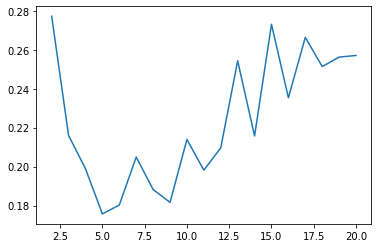

In [63]:
plt.plot(range(2, 21), sils)

In [64]:
clusterer = KMeans(n_clusters=10, random_state=15)
y_hat = clusterer.fit_predict(X)
domain_embeddings['labels'] = y_hat

In [65]:
domain_embeddings.head()

,domain,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,labels,x,y,str_label
0,5dariyanews.com,0.072099,-0.172862,0.406264,-0.230372,-0.204313,-0.545771,-0.775182,-0.072667,-0.130043,...,-0.325608,-0.095996,0.161377,0.377077,0.161172,-0.222423,1,-5.575626,-7.659633,3
1,aajtak.in,0.524727,-0.196843,-0.115742,-0.586768,-0.160513,0.273535,-0.202363,-0.120045,0.198843,...,0.065533,0.840599,0.274415,0.749437,-0.481876,2.443965,4,-3.714161,17.800657,4
2,aappune.org,0.326274,0.685605,-0.050902,-0.025892,0.137985,-0.059456,-0.145549,0.219138,-0.537966,...,-0.681800,0.081884,-0.800482,0.325498,-0.322816,-0.239820,5,-11.532399,-4.161236,1
3,abplive.com,-0.055227,-0.484994,-0.267594,0.051285,-0.296889,-0.068106,-0.163805,0.244055,0.009744,...,-0.294345,0.942371,-0.157442,0.281270,-0.446830,2.287188,4,-4.731057,18.323849,4
4,abpnadu.com,0.080810,-0.051547,0.102080,-0.001201,0.246721,-0.105467,-0.003670,-0.066830,-0.504084,...,-0.144679,-0.460595,0.224267,-0.752368,-0.120762,-0.195781,6,18.560223,3.738194,2


## TSN-E viz

In [66]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape


(347, 2)

In [67]:
domain_embeddings['x'] = X_embedded[:,0]
domain_embeddings['y'] = X_embedded[:,1]

In [68]:
domain_embeddings.head()

,domain,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,labels,x,y,str_label
0,5dariyanews.com,0.072099,-0.172862,0.406264,-0.230372,-0.204313,-0.545771,-0.775182,-0.072667,-0.130043,...,-0.325608,-0.095996,0.161377,0.377077,0.161172,-0.222423,1,8.193967,-7.155622,3
1,aajtak.in,0.524727,-0.196843,-0.115742,-0.586768,-0.160513,0.273535,-0.202363,-0.120045,0.198843,...,0.065533,0.840599,0.274415,0.749437,-0.481876,2.443965,4,-17.839096,8.206231,4
2,aappune.org,0.326274,0.685605,-0.050902,-0.025892,0.137985,-0.059456,-0.145549,0.219138,-0.537966,...,-0.681800,0.081884,-0.800482,0.325498,-0.322816,-0.239820,5,12.414890,-2.201211,1
3,abplive.com,-0.055227,-0.484994,-0.267594,0.051285,-0.296889,-0.068106,-0.163805,0.244055,0.009744,...,-0.294345,0.942371,-0.157442,0.281270,-0.446830,2.287188,4,-17.380970,9.324929,4
4,abpnadu.com,0.080810,-0.051547,0.102080,-0.001201,0.246721,-0.105467,-0.003670,-0.066830,-0.504084,...,-0.144679,-0.460595,0.224267,-0.752368,-0.120762,-0.195781,6,5.180560,16.686617,2


In [69]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

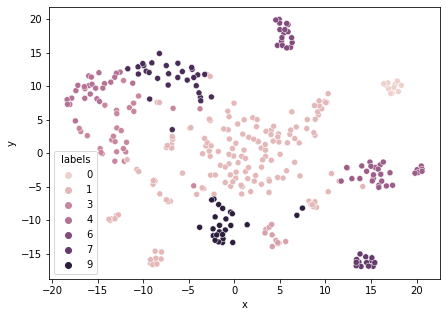

In [70]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='x', y='y', hue='labels', data=domain_embeddings)

In [71]:
from bokeh.models import HoverTool, LabelSet
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import Legend
from bokeh.models import CategoricalColorMapper
#CategoricalColorMapper(palette=["red", "blue"], factors=["foo", "bar"])
from bokeh.transform import factor_cmap


domain_embeddings['str_label'] = domain_embeddings['labels'].apply(lambda x: str(x))

# from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
# color_map = CategoricalColorMapper(palette=[0,1,2,3], factors=['#FF0000','#FF8000','#00FF00','#0080FF'])
#color_map = {0:'#FF0000', 1:'#FF8000', 2:'#00FF00', 3:'#0080FF'}
x = X_embedded[:,0]
y = X_embedded[:,1]
author_names = domainIndex

# # Radius of each point corresponds to the number of documents attributed to that author.
# scale = 0.1
# author_sizes = cooccurrences.sum(axis=1).getA1()
# radii = [np.log(size) * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
#             author_sizes=author_sizes,
            author_types=domain_embeddings['str_label'].tolist(),
#             radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        #("size", "@author_sizes"),
        ("type", "@author_types"),
        ]
    )

index_cmap = factor_cmap(field_name='author_types',palette=['#FF0000','#FF8000','#00FF00','#0080FF'], 
                         factors=['0','1','2','3'])


p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'], plot_width=500, plot_height=500)
p.scatter('x', 'y', source=source,
          #fill_color=index_cmap,size=10,
          color=index_cmap, size=10,
          fill_alpha=0.8, line_color=None)

output_file("foo.html")
show(p)

In [55]:
domain_embeddings.loc[domain_embeddings['labels']==1].head(50)

,domain,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,labels,x,y,str_label
2,aappune.org,0.326274,0.685605,-0.050902,-0.025892,0.137985,-0.059456,-0.145549,0.219138,-0.537966,...,-0.681800,0.081884,-0.800482,0.325498,-0.322816,-0.239820,1,-11.532399,-4.161236,1
6,agrowon.com,-0.291784,0.439710,0.317344,-0.085404,0.361848,-0.169971,0.398016,0.178241,-0.587051,...,-0.557782,0.233133,-0.916862,0.325647,-0.397205,-0.235405,1,-12.068311,-5.770652,1
62,dkoding.in,-0.244556,0.650485,0.506093,-0.271003,0.322687,-0.193692,0.136140,0.198878,-0.506834,...,-0.592391,-0.113339,-0.403902,0.408065,-0.212366,-0.156729,1,-10.516299,-6.015656,1
70,enavabharat.com,-0.088899,-0.077776,0.143534,0.066712,-0.158444,-0.036596,0.346578,-0.002151,0.047685,...,-0.080683,-0.357943,-0.715326,0.190283,-0.308106,0.019991,1,-13.990904,-7.679844,1
73,esakal.com,0.224219,-0.186760,-0.137371,-0.270021,-0.219926,0.081650,-0.114938,-0.056373,0.119281,...,0.215088,-0.373904,-2.147711,0.218499,-0.395411,0.511550,1,-19.264555,-4.528263,1
95,hindusthanpost.com,-0.142514,-0.268511,0.017812,0.201077,0.107860,-0.142944,0.242137,0.000985,-0.372077,...,-0.612104,0.226368,-1.326134,0.190428,-0.336680,-0.279179,1,-14.625579,-6.101984,1
104,indiadarpanlive.com,-0.437228,0.837864,0.601770,-0.262472,0.529026,-0.287446,0.154243,0.188984,-0.608662,...,-0.603604,-0.005366,-0.680210,0.347353,-0.202481,-0.166353,1,-10.694458,-5.920973,1
119,jaimaharashtranews.com,-0.375770,-0.468204,0.189716,-0.036917,0.162249,-0.113817,0.303660,-0.171631,0.040032,...,-0.619097,0.171782,-1.123293,0.186074,-0.259513,-0.218151,1,-15.237927,-7.133700,1
144,krushirang.com,0.397908,0.633324,-0.091160,-0.070065,0.127578,-0.074638,-0.195150,0.253400,-0.513369,...,-0.646411,0.148681,-0.739471,0.288603,-0.283719,-0.238122,1,-11.444460,-4.116364,1
152,lokmat.com,0.117516,-0.266393,-0.187972,0.176774,-0.054726,-0.286368,0.164510,-0.038178,0.148646,...,-0.072985,-0.200325,-1.915783,0.344221,-0.314420,1.183691,1,-20.006124,-4.581787,1
